In [ ]:
from IPython.display import clear_output

!pip --quiet install python-binance

clear_output()

In [ ]:
import json
import requests
import numpy as np
from collections import defaultdict
from requests.auth import HTTPBasicAuth

import matplotlib.pyplot as plt

from binance.client import Client

# client = Client()

In [ ]:
def get_location():
    response = requests.get("http://ip-api.com/json/")
    if response.status_code == 200:
        location_data = response.json();return location_data
    else: return None

location = get_location()

if location:
    ip = location['query']
    city = location['city']
    region = location['regionName']
    country = location['country']

    print(f"IP: {ip}")
    print(f"City: {city}")
    print(f"Region: {region}")
    print(f"Country: {country}")
else:
    print("Unable to retrieve location data.")

IP: 34.27.121.168
City: Council Bluffs
Region: Iowa
Country: United States


In [ ]:
### current balance
def get_btc_balance(address):
    """
    Retrieves the Bitcoin balance for a given BTC address.

    Parameters:
    - address (str): The BTC address for which the balance is to be checked.

    Returns:
    - float: The Bitcoin balance of the provided address.

    Example:
    >>> get_btc_balance("1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa")
    50.0

    Note:
    The balance is fetched from the blockchain.info API and is returned in satoshis,
    so the function converts it to BTC before returning.
    """
    url = f"https://blockchain.info/q/addressbalance/{address}"
    response = requests.get(url)
    btc_balance = int(response.text) / 1e8
    return btc_balance

def get_btc_price():
    """
    Retrieves the real-time price of Bitcoin in USD.

    Returns:
    - float: The current price of Bitcoin in USD.

    Example:
    >>> get_btc_price()
    50000.0

    Note:
    The price is fetched from the blockchain.info API's ticker endpoint.
    """
    url = "https://blockchain.info/ticker"
    response = requests.get(url)
    data = response.json()

    # The 'USD' key provides details about Bitcoin price in USD
    btc_price = data['USD']['last'] if 'USD' in data else None
    return btc_price

def convert_balances_to_usd(address, ETHERSCAN_API_KEY, BSCSCAN_API_KEY, balances, json_paprika):
    """
    Convert token balances to their corresponding value in USD.

    Parameters:
    - address (str): The address for which the balances are being converted.
    - balances (dict): Dictionary containing tokens and their balances.

    Returns:
    - dict: A dictionary with token symbols as keys and their USD values as values.

    Example:
    >>> balances = {'ETH': {'balance': 2, 'contract': '0x123...'}}
    >>> convert_balances_to_usd('0xabc...', balances)
    {'ETH': 5000.0}
    """
    balances_usd = {}

    for token, info in balances.items():
        balance = info['balance']

        if token.lower() == 'wbnb':
            token = 'BNB'
            balance = get_bsc_balance(address, BSCSCAN_API_KEY)
        elif token.lower() == 'weth':
            token = 'ETH'
            balance = get_eth_balance(address, ETHERSCAN_API_KEY)

        price = get_token_price(token.lower(), json_paprika)  # CoinGecko and CoinPaprika use lowercase token symbols
        if price is not None:
            balances_usd[token] = balance * price
        else:
            # Indicates we couldn't fetch the price for this token
            balances_usd[token] = None

    return balances_usd

### transactions
def get_btc_transactions(address):
    """
    Fetch BTC transactions for a given address from the Blockchain.info API.

    Parameters:
    - address (str): The BTC address.

    Returns:
    - list: A list of transaction objects.
    """
    url = f"https://blockchain.info/rawaddr/{address}"
    response = requests.get(url)
    data = response.json()
    return data['txs']

import requests

def get_address_balance(api_key, address, symbol):
    # url = 'https://www.oklink.com/api/v5/explorer/blockchain/summary'
    url = f'https://www.oklink.com/api/v5/explorer/address/address-summary?chainShortName={symbol.lower()}&address={address}'
    headers = {
        'Ok-Access-Key': api_key,
        'Content-type': 'application/json'
    }

    response = requests.get(url, headers=headers)
    data = response.json()
    return float(data['data'][0]['balance'])

In [ ]:
def get_address_transactions(api_key, address, symbol):
    # url = 'https://www.oklink.com/api/v5/explorer/blockchain/summary'
    url = f'https://www.oklink.com/api/v5/explorer/address/transaction-list?chainShortName={symbol.lower()}&address={address}&limit=50'
    headers = {
        'Ok-Access-Key': api_key,
        'Content-type': 'application/json'
    }

    response = requests.get(url, headers=headers)
    data = response.json()
    return data['data'][0]['transactionLists'], data['data'][0]['totalPage']

In [ ]:
btc_address = 'bc1qcdqj2smprre85c78d942wx5tauw5n7uw92r7wr'
btc_address = '34xp4vRoCGJym3xR7yCVPFHoCNxv4Twseo'

In [ ]:
API_KEY = "f17231f0-a70f-4e94-a6b2-206f1c130cfd"
API_KEY2 = '31f9bae4-729b-4416-9d2e-670e02ce5b2b'
symbol = 'BTC'

btc_balance = get_address_balance(API_KEY2, btc_address, symbol)
btc_balance

16418.06856349

In [ ]:
data, total_t = get_address_transactions(API_KEY2, btc_address, symbol)
total_t

'17'

In [ ]:
len(data)

50

In [ ]:
data[0].keys()

dict_keys(['page', 'limit', 'totalPage', 'chainFullName', 'chainShortName', 'transactionLists'])

In [ ]:
data[0]

{'txId': 'ebaa6adb629fb166ba51d0adc5db5026574f772d0f595642a25b94a2cfa93841',
 'methodId': '',
 'blockHash': '000000000000000000050647e14c553f19af99742a5bd3434cc31ef9c40e13e5',
 'height': '802584',
 'transactionTime': '1691718691000',
 'from': 'bc1qjq2gahpvwxezcnskeffs5fck6wt06qgs0ne648',
 'to': '34xp4vRoCGJym3xR7yCVPFHoCNxv4Twseo',
 'isFromContract': False,
 'isToContract': False,
 'amount': '0.00033971',
 'transactionSymbol': 'BTC',
 'txFee': '0.0000333',
 'state': '',
 'tokenId': '',
 'tokenContractAddress': '',
 'challengeStatus': '',
 'l1OriginHash': ''}

In [ ]:
(1e6*np.array([1691718691000, 1672098850000])).astype("datetime64[ns]")

array(['2023-08-11T01:51:31.000000000', '2022-12-26T23:54:10.000000000'],
      dtype='datetime64[ns]')

In [ ]:
(1e6*np.array([1692041803000, 1691723761000])).astype("datetime64[ns]")

In [ ]:
data[-1]

{'txId': '0f2c5c8d9187ed27fffe1ebe93fdce5a01d139fe2e30acc27ac81f865138bc37',
 'methodId': '',
 'blockHash': '0000000000000000000440425c33be9b95bbd63dea7f252afb827bdb4580183b',
 'height': '769047',
 'transactionTime': '1672098850000',
 'from': 'bc1qx4kpu9cyqwtg6ewm787l8ed7fp9nz8vzutalfq',
 'to': 'bc1qx4kpu9cyqwtg6ewm787l8ed7fp9nz8vzutalfq,34xp4vRoCGJym3xR7yCVPFHoCNxv4Twseo',
 'isFromContract': False,
 'isToContract': False,
 'amount': '0.00008893',
 'transactionSymbol': 'BTC',
 'txFee': '0.00003281',
 'state': '',
 'tokenId': '',
 'tokenContractAddress': '',
 'challengeStatus': '',
 'l1OriginHash': ''}

In [ ]:
btc500_ = ['34xp4vRoCGJym3xR7yCVPFHoCNxv4Twseo', 'bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97', 'bc1ql49ydapnjafl5t2cp9zqpjwe6pdgmxy98859v2', '39884E3j6KZj82FK4vcCrkUvWYL5MQaS3v', 'bc1qazcm763858nkj2dj986etajv6wquslv8uxwczt', '37XuVSEpWW4trkfmvWzegTHQt7BdktSKUs', '1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF', 'bc1qa5wkgaew2dkv56kfvj49j0av5nml45x9ek9hz6', '3LYJfcfHPXYJreMsASk2jkn69LWEYKzexb', 'bc1qd4ysezhmypwty5dnw7c8nqy5h5nxg0xqsvaefd0qn5kq32vwnwqqgv4rzr', 'bc1qjasf9z3h7w3jspkhtgatgpyvvzgpa2wwd2lr0eh5tx44reyn2k7sfc27a4', '1LdRcdxfbSnmCYYNdeYpUnztiYzVfBEQeC', '1AC4fMwgY8j9onSbXEWeH6Zan8QGMSdmtA', 'bc1qm34lsc65zpw79lxes69zkqmk6ee3ewf0j77s3h', '1LruNZjwamWJXThX2Y8C2d47QqhAkkc5os', '3LCGsSmfr24demGvriN4e3ft8wEcDuHFqh', '38DN2uFMZPiHLHJigfv4kWC9JWJrNnhLcn', '3LQUu4v9z6KNch71j7kbj8GPeAGUo1FW6a', 'bc1qjh0akslml59uuczddqu0y4p3vj64hg5mc94c40', 'bc1q7ydrtdn8z62xhslqyqtyt38mm4e2c4h3mxjkug', 'bc1qjysjfd9t9aspttpjqzv68k0ydpe7pvyd5vlyn37868473lell5tqkz456m', '3MgEAFWu1HKSnZ5ZsC8qf61ZW18xrP5pgd', '12XqeqZRVkBDgmPLVY4ZC6Y4ruUUEug8Fx', 'bc1qx9t2l3pyny2spqpqlye8svce70nppwtaxwdrp4', '3FHNBLobJnbCTFTVakh5TXmEneyf5PT61B', '12ib7dApVFvg82TXKycWBNpN8kFyiAN1dr', 'bc1qf2yvj48mzkj7uf8lc2a9sa7w983qe256l5c8fs', '1Ay8vMC7R1UbyCCZRVULMV7iQpHSAbguJP', '12tkqA9xSoowkzoERHMWNKsTey55YEBqkv', '19N9sDbJ7MDQcPFSjPNqjNDzyRNbNsQ6Zv', '1aXzEKiDJKzkPxTZy9zGc3y1nCDwDPub2', '17MWdxfjPYP2PYhdy885QtihfbW181r1rn', '38UmuUqPCrFmQo4khkomQwZ4VbY2nZMJ67', '19D5J8c59P2bAkWKvxSYw8scD3KUNWoZ1C', '3G98jSULfhrES1J9HKfZdDjXx1sTNvHkhN', '1932eKraQ3Ad9MeNBHb14WFQbNrLaKeEpT', '1m5SViB9XNwsusvnnUqpfL9Q1E5EZxPHs', '15cHRgVrGKz7qp2JL2N5mkB2MCFGLcnHxv', '17rm2dvb439dZqyMe2d4D6AQJSgg6yeNRn', 'bc1q4c8n5t00jmj8temxdgcc3t32nkg2wjwz24lywv', '3EMVdMehEq5SFipQ5UfbsfMsH223sSz9A9', '1PeizMg76Cf96nUQrYg8xuoZWLQozU5zGW', 'bc1qyg4z96sy84594r4a28mc8esdkkuj4dq08jmtt5', '39gUvGynQ7Re3i15G3J2gp9DEB9LnLFPMN', '3JZq4atUahhuA9rLhXLMhhTo133J9rF97j', 'bc1qkz55x35wlnrkrn5n0nq4wwsme9vszrwavu5qf4', 'bc1q5vwscmf85w2vlq0qvr33dgpvu5rlrd42cqw6qn', '3Qxak1CZhLyZ7GVckKphLURdLBCjMfz9bA', 'bc1qtrxc0use4hlm7fl0j6t37z7qlwl5eppj8lywz6', '3H5JTt42K7RmZtromfTSefcMEFMMe18pMD', 'bc1qcdqj2smprre85c78d942wx5tauw5n7uw92r7wr', '34HpHYiyQwg69gFmCq2BGHjF1DZnZnBeBP', '1BAuq7Vho2CEkVkUxbfU26LhwQjbCmWQkD', 'bc1qx2x5cqhymfcnjtg902ky6u5t5htmt7fvqztdsm028hkrvxcl4t2sjtpd9l', '1GR9qNz7zgtaW5HwwVpEJWMnGWhsbsieCG', '35pgGeez3ou6ofrpjt8T7bvC9t6RrUK4p6', '1Pzaqw98PeRfyHypfqyEgg5yycJRsENrE7', '1KVpuCfhftkzJ67ZUegaMuaYey7qni7pPj', '1BZaYtmXka1y3Byi2yvXCDG92Tjz7ecwYj', '3FupZp77ySr7jwoLYEJ9mwzJpvoNBXsBnE', 'bc1q4vxn43l44h30nkluqfxd9eckf45vr2awz38lwa', '1LyRYNfsTD3vyBSVtTQqpWnRwKvZLCDGj8', '3BMEXqGpG4FxBA1KWhRFufXfSTRgzfDBhJ', '1FZy7CPFA2UqqQJYUA1cG9KvdDFbSMBJYG', '31oxjGsmepoq2cipeGQ2zKZRRBCf1m3kAC', '1DNUjpHPNKMoKYBHxJz2Sh1uQQdJkGsXj5', 'bc1qcdeadk07jkthules0yw9u9ue9pklvr608ez94jgwcf7h2ldzcg6qwxp9er', '1JrFAUp3KP3ez8187EJCJXL9mTc3iuiuxX', '1Cr7EjvS8C7gfarREHCvFhd9gT3r46pfLb', '1JHceFenZHACSRPD6tE4bfU6yJ83wTG6kH', '3A9qNS69dngSU2ak8BwZKEExeVnL2RqpYJ', 'bc1q080rkmk3kj86pxvf5nkxecdrw6nrx3zzy9xl7q', '1F34duy2eeMz5mSrvFepVzy7Y1rBsnAyWC', 'bc1qhd0r5kh3u9mhac7de58qd2rdfx4kkv84kpx302', '385cR5DM96n1HvBDMzLHPYcw89fZAXULJP', '36zSLdRv1jyewjaC12fqK5fptn7PqewunL', '1f1miYFQWTzdLiCBxtHHnNiW7WAWPUccr', 'bc1qsxdxm0exqdsmnl9ejrz250xqxrxpxkgf5nhhtq', 'bc1qtef0p08lputg4qazhx2md43ynhc9kp20pn297qnz68068d9z48asmemanj', '1BAFWQhH9pNkz3mZDQ1tWrtKkSHVCkc3fV', 'bc1qe75775tzuvspl59cw77ycc472jl0sgue69x3up', '14YK4mzJGo5NKkNnmVJeuEAQftLt795Gec', '1Ki3WTEEqTLPNsN5cGTsMkL2sJ4m5mdCXT', '1KbrSKrT3GeEruTuuYYUSQ35JwKbrAWJYm', '1P1iThxBH542Gmk1kZNXyji4E4iwpvSbrt', '12tLs9c9RsALt4ockxa1hB4iTCTSmxj2me', '1ucXXZQSEf4zny2HRwAQKtVpkLPTUKRtt', '1CPaziTqeEixPoSFtJxu74uDGbpEAotZom', '1GUfWdZQoo2pQ4BKHsiegxuZPnheY5ueTm', '12HnxiXEeKUVjQRbMVTytsGWnzHd5LdGCt', '17uULjz9moeLyjXHoKNwDRgKzf8ahY3Jia', '18qNs1yBGGKR8RyErnEF5kegbNUgPfixhS', '1MewpRkpcbFdqamPPYc1bXa9AJ189Succy', '1DzsfLRDfbmQM99xm59au2SrTY3YmciBSB', '1MtUMTqtdrpT6Rar5fgWoyrzAevatssej5', '1NhJGUJu8rrTwPS4vopsdTqqcK4nAwdLwJ', '1DP3VYwN6ozHXDDaETbvNFLd86CAXfaewi', '1H2MXWiSniAgg7ykdXEzPHL6oTH1ic4kP', 'bc1q5nfww5jn5k4ghg7dpa4gy85x7uu3l4g0m0re76', '1LnoZawVFFQihU8d8ntxLMpYheZUfyeVAK', '1JQULE6yHr9UaitLr4wahTwJN7DaMX7W1Z', '1DcT5Wij5tfb3oVViF8mA8p4WrG98ahZPT', '1CY7fykRLWXeSbKB885Kr4KjQxmDdvW923', 'bc1qvy0sp8cdj3cv2wwh05scucxw6vxqpdlhfjvqn8', 'bc1qm6q8tgml3cr9gpx63a5jqtj2dxlsyz4q3ghjlf', 'bc1q4srun4yspqem2pqgk47eq9jspcht3fmyrmfdeu', 'bc1qe39l9l84sa44r9j2jjkgdc7p4ltj3sracd932k', 'bc1qdhvtwg0eealy5d2spua2a89sq05ydvtgjy4uau', '35WHp4Hid61peyH4tuhNunwRj2gtNB41Lo', 'bc1q4ffskt6879l4ewffrrflpykvphshl9la4q037h', '1E1SKgxgYJFXzaLxgat2FNSnwWeKz1U15N', 'bc1q4jchcr7nla277su5lpjzttxp3xg5j8wds5lcwg', '39DUz1NCkLu25GczWiAjjgZBu4mUjKbdNA', '1KLay1g7rZxAiotuDhGy5YizdXSpqkFxQ9', 'bc1qsm3kjcmp63jsuyrqh58kc6k4ydpactjy6r7a6f', '1gvH7pGPrEBNjqmwYS8UDhjFQkyqkKCLE', 'bc1qrj8jwwea530rx00ldc22w8mnaclae4m54e6tgy', 'bc1qajh7jfy44sswutqlwj2tz9wcejpxrgflc8penw', '1P9fAFAsSLRmMu2P7wZ5CXDPRfLSWTy9N8', '33eU1zeB2S4x3p4ccSsnAChXcGJgtMrMtZ', '12yePmcVhMzzHYwh4BpVF3Cm1bYL9mqyKc', 'bc1q6kyur2rn044ddp4j9gtdlswhdyrg7u7t9c0j36', '1HLvaTs3zR3oev9ya7Pzp3GB9Gqfg6XYJT', '1BbSZNNhoBUCFGMfnscBDXf7PH1takoMga', 'bc1qh4cpaydaqlzez8ekkasm3ygj4us7gwxsghh047', 'bc1q78wmm8xnhveklsparpeq6drlg9wlq4lyahkqfp', 'bc1qvhxafz8dqk8c25jsx669yd6qrxhl5dx72dyryp', 'bc1qzkqmyv57jpuntyc9ydjyrq4hlneevrmr0xe9kz', '1J1F3U7gHrCjsEsRimDJ3oYBiV24wA8FuV', '1KNm4K8GUK8sMoxc2Z3zU8Uv5FDVjrA72p', '3C8mzzeiyakvXkQadUM5f98zCt5NQWwXo1', '167ZWTT8n6s4ya8cGjqNNQjDwDGY31vmHg', '39wVd42giU95ca39sEPkbPTpWygvsBDuA5', '12qTdZHx6f77aQ74CPCZGSY47VaRwYjVD8', 'bc1qzk2pyxtahg64cx6gyq02vrw65fdxtpr253r4ygww9n2w2zjyy8wsnyc666', 'bc1qhszrd0ef5we6mg3r7xgl05g8rx06xll8yrwmjh', '187zSqAYwMKJAxWdWQ4fmp5DyT6G2NPgD7', '1FzyryYKneS4wTrKKZUyP3oJXkiyRsMYfr', 'bc1qukuxeth2kfk72kzjuv6ls8z59zpy6asqvgt3ue', '1Le1X8LJb4VkFsfktiUY7V7wMRhniu5Xgn', '15URsTiy1ksoMMV7DuEi9hvSqHgqobAtKa', '1Fjom9b9wvp3HPi2ZS9hqXQwJpXcjumSYJ', '16BiUbH8yxFmCJs4ArtyTgHKfXQFvkvPNr', '16dyizLarM2N4UjGaEFPESNmJC5vEALtZX', '1Gtpfqoo8stQw2E4vCbZZbJBBZvYzzCeRy', '1Eqj1APg1dkcPH7CmHJ6SzRwtJRLpxtBFA', '1MwQyJLNerHPVMTQXKAbQrnwF9VortvuAf', '19F4xZNBxtPAdMqFudr2LDH5efeeUYF21x', '157ZXCYfK6NqBiFLkoLDt3PN8KyE8xdTu5', 'bc1qxsng2xa4dqv2ggra88tgrzp4a5hlpc4c8a5whv7mzzrmtuv3qmfsmvjrn3', '1GaX3bQPsqSPk9zYGCCNkQrbinw2NhWBuV', '14ACC7ftHQS6guKJi3FCTEyCw94dHnRZjJ', '13AiVabLoTcYTdaFcFYtpFFmCFagjiUwE2', '19yLTkx4jggSnjdiGkkhNwTjZUyY5T8kEA', '1CsAkAsjTTRAuRw39fRQj7pxKn3fjEuYsT', '1GcPTDtNXuPghJU5qSGvkPQ99nhWrbQaYR', '1GaSQcWg3R98qf5sTWetwjjMh6ehxj25Gp', '1GBzbXJmcMjnDyTW2yKJFfeXUGicG1zpC4', '13TM7PLtf1Ujo9t9pk9RSyrv1ts119PNK5', '1MH8s3qc4F2GZNod1R43qeysSB2ssZCXb', '12T7nyMrAnd13UAMYCCJZ8Fw7PpMGPRFsi', '1LjUYdf8mQk9DsrVvuPYeHyJKQq5V1MLsT', '18zuLTKQnLjp987LdxuYvjekYnNAvXif2b', '3PWn1AGqo8HWH8mXSsxx1Ytk87zMAAziFU', '198aMn6ZYAczwrE5NvNTUMyJ5qkfy4g3Hi', '18f6y4uWnLd7VPzfR2c1dMboihghXYHRH3', '1Lan1sQzYGViDZskUFmnitJvfejn2jYdNS', '17RmGC3i2dASQai3mP9iJLX3ZD9TBm2YQV', '15mxk4fKk9ggQ4fikNWKpasahsdXZNdVu2', '1HGdi2AtuvBUcdTFe62sKd7ZAFzoG7iQLb', '1Fn4FSiHFr9SgbQ3ccsybN9f3RF1omst4x', '1FDzP5vQGMhCzeb9nH4AcUDnUbcHS22BMZ', '17GyU83L63BtxtpDgv8LmhhtmvcrXbfVt1', '1NJdKoBkKQNg6aYL9HTKyQ5SgfjZQDz3y3', '17J26KSDtNFPAUhCMwjcRNWhneMsXS75Ba', '12US3aeNibsxe7Lhascm4AmvGiTxwSdD4X', '1DdxS8CheskxKAPPbG8Uq4Qts8kS4x1tt2', '1Dr1pZDgpowHDGJrUNTithDL33TdriFMzE', '1N4yKFsFPjjoJyo3BAKUWpcs3SUghfgJkH', '16H2Fe9MgxZ1jXW3TaXbgWh3SJfwyxQUTp', '1KoiNofDvcUrrVfxgqpRZixWXNXo6d2kfQ', '1FMbcnYvvccZ6hR324cFRpn1QX9TCkqtAe', '1LRXrhZRLVTjGCPFphPsXZfeHesRigm59r', '15QFkJUWFZ6QRpTrzUitH2Egyf1JTngVgV', '12mJZGPCWf5C2ap2dUdJiuGr8eWAvi6E5M', '1GBWcQuY5aD6e2zrbdb38j7pizVr2wcJnC', '1NQWCZqRYvANz3iX1Wnczpm277VEYvcAee', '1T7m8nSs5Yh3YuLNoHPb5ehwN3LRVEchn', '1HG6NbWmJjjSE1Z6oPetWG3nnKrQxgBN3a', '1FrfmxAhYRNU9ebotDHP9FqLbe54QZVcfi', '1FtHBKrYkDchMA1pwRTpYZ77TpfwSgh6iF', '1JeTiSWo8pYWcNaTH4c3CfheAwVDYRoy1Q', '17wADqWPK8wZfpRmPkauviq2VDBmhm82rM', '1AfHER73jneZAEAHNiz5dBKnrzeWcMJM5i', '1NJdqNoC7uPh7MqQhyEynRn9htstEELZDn', '1EUgoa25tkqMUYh7PXzDfqqNP5PtHKZmct', '1LuEe5Xkf1eA493SvsKwjPTS9RkW9JV9N2', '1Ja7G9JJRw8w8WWnMzw7PwYehhiZmhESkC', '15TbabdR3FKJMpRxDeEetezWKGJwdGXbTY', '1CptxmzfRyU2rF3VJ6q8wa2tkh3cm82p9P', '1PnsNtAqmHQKxyqKS843J9aegdJsXr5rpD', '1AXskHt4ZwVZLonZV8BMDxh4V65ec41KMJ', '1JnfbQerGjFHVq28945y1bhoUHpn6vKM9v', '1BcAtWddaU1jHWgQvM7dpM5SefoVgUHEuC', '15Z5YJaaNSxeynvr6uW6jQZLwq3n1Hu6RX', '34ovCavdkQgEYbrJk9Q1onhK7uWqq6J7DC', '1B4U28Yc1JmSQbpzzSfavEskTPMvBRphyD', '3HfD4pvF43jdu9dzVMEr1b8AnDHooRGc5t', '3CG73de45sR9cYLFAkzF6peRai1Q44R923', '1K8QG4fuswaWFZ2fmmuxVKaWibi9H95iGw', '14vbdGfYS7UKMvc4334UZDvTMPFA2G7zCB', '3HCdgNiAsjidcGx4eeMK9AXvXBfrnteunW', '18J25HxUXiaoTDDpES1V7iEimNMQZDWneY', '1DwSAnZw4Gk9FotgWZhRb3Nzqi4PLdU8M', '1JECFWTZsRw65y65DEVR2djXv2KMYfuo7A', '1JKDzFHcb6KBybKSquvMw1FrxXhvBdMiB5', '1361wC48gW19mKAJmAkdXScLZKYdXgViS9', '1Mt6STNGoHGuDziUSCagqTGNGrbDFSBxRn', '19VBqLkbMywnX5QMUg7LsHgbzsLh9as4MS', 'bc1qhk0ghcywv0mlmcmz408sdaxudxuk9tvng9xx8g', '1Q8QR5k32hexiMQnRgkJ6fmmjn5fMWhdv9', '1M14kQL3zfyEAHx6JCM3gsZyAxyiSDMWdp', 'bc1qdz0d6e69fdmwxf5c0hspl7nml7c2xn69duhggj', 'bc1qk2q9ptkvfrtt3769hh85zvq88jyrulk6zgys2h', '19tiUa9nsPTgaqWNHaM9QyCfv4Wm9dVeYa', '1JFUG5K3HidvfJD4R7nKyDJikmFpPcBB2', '1C1sUtw6fYa1Yr5wexrH2ayT1ZykD9Sobx', '19RtRzXV5px91eMbWZFCWLZRUeQX5XxxnJ', '1FZcb6BU1ZbHQJcby7vDF2Na1z9UmkGSSG', '1P3AfqQ9cdrr7TKUexuWQoyvhYZu8wFeTh', '1NS8nuYymh5eY1kNhzdKbfcsbfMofF53eH', '1JfXLzQvYPZHNzX4vhH6aoetGDfcPD1YEX', '13eEt6myAo1zAC7o7RK5sVxxCNCAgd6ApH', '1DzjE3ANaKLasY2n6e5ToJ4CQCXrvDvwsf', '15YMdTNT83UJqfpaZfDccy9yBYQFxHxVFt', '324rP14bzX8kW1JWt1J8ohZjDFyt2G68Kq', '1FJuzzQFVMbiMGw6JtcXefdD64amy7mSCF', '186XqVoL7TGxR3osoo4xn32wbYtb527raY', '1Ac2JdpQ5c9NeSajdGx6dofxeXkn4S35ft', '1CNtkWbb4grh8xtb8mhoZ6armNE9PHgzA8', 'bc1qms2la25qtgh69e7v8eddhsz3gwlfzucwh6v0zvwk8ku36r3mczxq4zlfd5', '1LYRCBD9DuBbcJrQLbKyh8SQ7Xh7RZEqEm', '391yXdEC53f2HMEKLZJMygzC3JedfCu5yP', 'bc1qyd2k46lzcrt3cd3z0nrt9d99z6xnzvyn2r83a5z9xfg8adpyp0ss53fnz4', '18SN8PV997oDGtYmTPPD55GDaPtNNEGWeu', '1AYLzYN7SGu5FQLBTADBzqKm4b6Udt6Bw6', '1NpZcfBnaJeoRT9ZqwZVRMw3SRs546VsuE', '3Ga3q89pTwHt6F8AScAurJ4XGERj1q41c6', 'bc1ql7c3k2xw90qmhpntte94mu7mpra6g77nqtj6v7', 'bc1qzxwdcxqj36ane625hkgjpg6p0pjg79u29qyrus', '18gYq8BpkbcizC4jZ9zyQxo2NBVEQ2p4hM', '18QCiLiXhko8pb4rqv3mCtC834tSTWHNij', '16b8LpbDa38xrAQHVVDrC3xyztPdRaX5a2', '1NFPNeet3ygvVZtDbxYeLECfs7g7vH8PSV', '1HmiKJMQH4569UMpeGX2QStUfpjx7pBKhW', '147sPaNaqeyQp8GS2oAUajhb9d4PZ9xAv9', '14Ngt4akcnVgaoAMxoMqz9rPcP3bYsGbbM', '3EHeQxMkEbH3wD69A9mL1WF2QhdJAEnqBv', '3JsY8m7nG2K2siHXzqto612u36hAzF7C6X', '1Mq54q43p6iCssCStAQt1gQubPciUfboL2', '1JxmKkNK1b3p7r8DDPtnNmGeLZDcgPadJb', '37TTwX8uGwjWApXL8GbwU9p7vHoAupCFcw', '31tkNKEijSr1uvZWnQeSjL1jVhDV7cwe75', '1LBBmkr9muf7RjjBbzQQvzNQpRRaVEnavs', '1JtAupan5MSPXxSsWFiwA79bY9LD2Ga1je', '1PjPfocmxS262puhYqUwaagE9zBJTZHGwK', '1MJZLeLbsoSf2kuDr5gAX3QE93BvhvqkCC', '1NSbFq6rCeSC1p2EBrov5R1uUTFRBu8tcs', '3KiC6mvNu5GBPnxKhtHKS88Km3UWVxhWtx', '193omEabjWnUE6MnEcWybuSLJ28oWRfdKQ', 'bc1qwr9u43smaw4rwgsnvuag3hmknlu90l2en6hnkg', '36NkTqCAApfRJBKicQaqrdKs29g6hyE4LS', '16rF2zwSJ9goQ9fZfYoti5LsUqqegb5RnA', '14qnYK6kPdoNbXhR7mTRa1gqyp2Ho6VKxK', '1AkJq3KKGpKQDVRzVYR6SxdzToM47nopdV', '1EMQxNyqsSLkguWJsQmGTjwdL7YqbRVcVF', '1JCozFUFS5TBAAbnrr9jRWDVQURo2kGeRq', '1J3B2ucUpWjWPPpejUCoLN93Gwz3q65CTd', '18DowXoMUQT5EU8zPTDTrq4hrwmi8ddCcc', '3AwUscZWWWqgkEg3t4Xb9kY6c281KDwHW2', '138EMxwMtKuvCEUtm4qUfT2x344TSReyiT', '162bzZT2hJfv5Gm3ZmWfWfHJjCtMD6rHhw', '1DFv3qVAbravZBZqHmoEphMDtTs2zXPYXk', '19CkUw43czT8yQctnHXNiB5ivNtibWbzqS', '13n67sFKgqLDKp8gx8Xvm6scdfY4ZeaU8p', '1ETseKYhuSh2JGqwAKon5QZTXSiCJkdKeb', '14UeyAD9rQCSJgdJzuzFgShq84gW62Bsat', '1DDWbJhKqfidczaHF1ugGP2KzPgcaU3tGD', '1HvZQX9XkFFaNa8d5VpwMcYkyebyp6cCXM', '1D3mERfHYY2e96HKUZUsXX7HqHkqUFEadv', '1EF3T11bL7yua2yJo4waaQ3RgewNwRnKMw', '1FvkWMMH9MDMACHqynrerzduaQ5AjjZKDA', '1Pim5uUAk1zKnvPZiRu1cmwrSWmqYpdgnX', '15SGg7PpcJ7bMhENw4gc3Qp4LT6c5uLGza', '1Cw9Kyr8hKsucXTtcwuGVqeBHDrnRtXC8D', '1DR93bfKVCUJkDvPuxbUAEtzYRaJEnwjNt', '154sxXJekWHQ5nPxkkaWnMghy4o9qWaNdU', '1Gc6ggvqHRRwyyx6rrW9Wn17bqzV7voWvD', '1Ly9nQEyaRQoRPSAE4dABrpav2SaAR383W', '152BK6BQa672Dy8PHf4JQtS27pBRBiYy6e', '1GuLYGgr9FZwCBBQfDmMiJfTF4cvyrJSeu', '1FUpBduq45UfULPACj1Phw9hRvwroJqYUX', '1AwimXdGoX8nR9dMagCDMGJQB62GNHgrqM', '1CCqLR8YrUMPFgYZWwLW8FkezbFjfeXD8n', '3HcEUguUZ4vyyMAPWDPUDjLqz882jXwMfV', 'bc1qq5lmushesdxnjkdy0zhcyxga4c9ykkapeqqnrj', 'bc1quv866t7ke929gxttpgc2u30ffnczpgfrjugwxv', '1EGFRYgqGjoBuN67Gzxn2RJhUmNgq2thRd', 'bc1q4mcyastjs4k9gfzrsua4l8mxy393d53a6nnd4r', '3AtnehKDkFPC1bKvdrEVPSRGCtxQH8F1R8', '3HroDXv8hmzKRtaSfBffRgedKpru8fgy6M', '3H3b3kxRwoKDnJbdV2JdhJ5h7iPsHgFN4B', '3MMaLANWuXzknhqDN2uUwksCDFfzEN4pm2', '1BVtDi7txPCG2TH5Crd2Rw5MtpivbmoKgB', '1D387jd5ZuvudpUQrSv8vK5b2M1SBnvdY8', '1BeouDc6jtHpitvPz3gR3LQnBGb7dKRrtC', 'bc1qs6cvad3kx9hn7wn32d0r2rwmpp5htfrpn88h044s42lx552se40q6fqexu', '1ByHahn2PDryrcyRvbSnQQsUsqXDN3uXPb', '1ARWCREnmdKyHgNg2c9qih8UzRr4MMQEQS', '3DwVjwVeJa9Z5Pu15WHNfKcDxY5tFUGfdx', '3JkfTdGnpNhK5xBjP6BzRsitZqnnVjQV1B', 'bc1qlfmc6nv27d62s6zygjnjt6wm28klfh2gltg6ym', '1LH1dY82QFtNGinBpCakU5WcTUKRyuztTz', '1DaCQDfStUgkPQXcf53Teeo6LPiKcVMBM9', '16Jka2DrvEGGJ6ks2kXRpxmQZLQmAFRoGk', '19z6WynrjHeD5MMv6919BuQRwybuen1sRv', '1NQEV6T4avmPqUVTvgsKkeB6yc8qnSWfhR', '1NJQZhzYac89fDhQCmb1khdjekKNVYLFMY', '12ytiN9oWQTRGb6JjZiaoWMAvF9nPWdGX1', '14tw97z6cqCSeZeefti83ERS99ucqeB6XV', 'bc1qdxsg7cfsqrg8sq3cs8ptsafqs6drtyuxswrqga', 'bc1q2we5eqjj8je6lz9xwjattpc3pn4jejc5h0s70f', 'bc1qpp3v9k4g5hqjfztextp5nn9808lcru9j8m4n2p', 'bc1qeth6n6ryxexvkx34wnx3nuynun4474h3j0gkhw', '14f3x5v48f7b7QN6Lqt56Fg8jBQ7nVn26N', '3Dhk8F6KYvMyqHN1r4kAT8t7SceK7yDjA4', '34JXN4GpFN8YNwUwH6a1fGoG4PjDk95L5H', '1Btud1pqADgGzgBCZzxzc2b1o1ytk1HYWC', '34MSicAL7qVGkevFPLwyc9KohGzoUSnu3Q', '1BXZng4dcXDnYNRXRgHqWjzT5RwxHHBSHo', '1BvNwfxEQwZNRmYQ3eno6e976XyxhCsRXj', '1PPuNHJanckd7a1ddTM8Dpv4TqGF3ZqggK', '1PmtxPwpw4s4VBy45HfFwLfKvj3YDbG43w', '35j7hbYS9QnKHgdrJF4MozcYwax11J58DT', '17spLhCpZVdQXFz2ZL1aP5gRci6RFVNhrD', '1LAoErDuhs4CxrtammRTKAAfRqxihCg6Ji', '1Miy5sJZSamDZN6xcJJidp9zYxhSrpDeJm', 'bc1qncsa0qdrgsr58303gsnuwhd5vrm7hlkpd6klmf', '1Kq6hXXiSpdp9bg9hDDyqm8ZfvgZmzchjn', '174uzhhPu3tVNLw5fqEpQxPQaT3LS9eYsE', '3CP2CyMEDD7V2kjjHtJxdU2GyHcsst1UTd', 'bc1q2f0tczgrukdxjrhhadpft2fehzpcrwrz549u90', '3L9hddHJMnpE1qzofQ2TSvMiiMf5ejX1Yw', '3Pv6S8ZEcQLmXigA694aUZhVmnLUjNzxcc', '18VmXvkF4cgLi35RtMiHHDpvMjUCyVpQ9x', '15MdAHnkxt9TMC2Rj595hsg8Hnv693pPBB', '16aEn4p6hK4FMpLtJGpoQZMZ946sDg1Z6n', 'bc1qfkdljt8e3hqqk43nz7wsl4usrylsp4rl5d62p4', 'bc1qxhkn652vt72zy9n2s3mkv2dk5y7ny7dmt02lr4', 'bc1q2x6v47z3xhxu8suuzqtehf8t7v997g3cjhc6kl', 'bc1qd6dhl3px06pux9rmzw07rkd2kwj9ef36dwgqdg', 'bc1qgzxtj07yh9jhyv0aexm2y9s4un0lz57eejyrur', 'bc1q8wlq09pnue9hpl9r5r37zek2qapafjfhj85dgj', 'bc1q0r3hp96aqq4akjcalasn2v79nmvewasl2sjh84', 'bc1q4hm96naa2ydcqlxpwlvljvrnt5svm8ejcqnhj0', 'bc1qlnexsqagmk27ju9dmmvj470l6jsl4j6t4lm34x', '1MLiPwYjNACQHREFKwGtkPpWgd8PqpbuQ4', '1Ms4LPLVYWCyYTAqBcotXAeizHgE778abE', '1ZK5rrghS3Uhnra64LiuZVupa6WTSuPfF', '15n6GcFRFm3287FotAWunZe58D9yXx13AB', '1Cm9ugUjEUyMvjB3uWxESapa861uEtcVyc', '1G6KK2j1C7DAsPmQ6joZpAY4gN84z5Te4E', '12GQSEPmoCiw7zrWJbsYa5SD3hkKPSzyAq', '1CY3uBdj9ZypiiZUymr2kVSaByFdEbYrcU', '1F1oWf9jkERoyYgUBMbSaw7f6M9LD7tet2', '1FMvcwKWJvjRDAmbfw9sF5GgGHjdj4tWrk', '1FXHxbZ8HiGDCUrkainA9RKzqfHHkGi1hu', '18Hp8j2JMvwtPs1eqNaYEEVvuFpjQJRFVY', '16eb495TbiCRbRbZv4WBdaUvNGxUYJ4jed', '3N5Nny9doXSfjYh5k9XNdG8baE1kiayx5o', '3BHXygmhNMaCcNn76S8DLdnZ5ucPtNtWGb', '1JCrPqogEKEpM9fuFQV7LpF9e8cgf3YZ8m', '3Kzh9qAqVWQhEsfQz7zEQL1EuSx5tyNLNS', '1DTibFT2vzUhM3LjCL7PXUbwgv3KfhAD3Y', '124ixYbTUb5jBAsY5X9pJfimdc3x1qJSPu', '1GDsWXPNUqKp2AtqRNZuUgzoCChuJfpi6f', '1MGRMRJkMvEbmSRZxtA5zkAoZiDBEnrFGj', '1AN2EJMCyKn8dcfv8gonihvRPvyYuNUuQP', '1PPWcRj9k2oRr2uEJUQpmTo293a68tkjTX', '18hFBPU81kC8V4Dp4iwdwQHakKa5TW2ZkJ', '143gLvWYUojXaWZRrxquRKpVNTkhmr415B', '1GX7i8jG8DD1mG85BNnz7xybVhSmw84Uii', '3AkdQwc4Rmehi2ES8WvfGoLxBoHvgT639E', '3MsNDaaqfXQXWGVyJ6j5Q3NAeyUJKeozMm', '3ANziRvoBdNGkmGopgyhvzPuBvcL8sRL7S', '14uqXrpH41TmB1GX2yE5gtxgDTYDaXP4zp', '1gtmmzwhqUzhb8XoShHwgyrzbJwdZ47ok', '1LVYbnSX6f6vE2Zn4zs2oZ4eKyBgzkqaay', '1N5NqDWiLVqtU8mEzCNEeEbQVHwuGGChJs', 'bc1qcuau7cc50vfkmz2rsmps4k9wz9vqypp4wrnw7s', 'bc1qq7skuy3g82q9ldmc5sdx96gm8q88422y8zpmqr', '3ApgNNejCcWje21tA1kt5e2zx18Bhh82E5', '124YoiaSaUssbBeP5RukbSN9Evc3UJfwPj', '1eNYBayUb4UfZH1HEBeKZv1eLAB8MuXG7', '1VeMPNgEtQGurwjW2WsYXQaw4boAX5k6S', '18eY9oWL2mkXCL1VVwPme2NMmAVhX6EfyM', '1ALXLVNj7yKRU2Yki3K3yQGB5TBPof7jyo', '1LwBdypLh3WPawK1WUqGZXgs4V8neHHqb7', '1MPsPzkBK3w8J6CJyAFUkoiSaxTqWRabsk', '1HJDQbLauXEkzsTujzw5PaAqbcDCBeLiq1', '16NR8enBCtweizoWsFGPapZmxb6eMMwsZ3', '3NFRWQSeWhuWUWPL67Dk52JYNFREiVhVH5', '36V2wui1dTbDw4jQExByau6hVopSQGN3be', '1JUuAaHSuxy4hSuBz3HknjLdCtmL28Hcj8', '1DWB2HajYBcDBuB2iSGzRVaCpcQKEPvCsj', '15MZvKjqeNz4AVz2QrHumQcRJq2JVHjFUz', '35h3wuHCVzuULtL7nRtYq9bzWVRR554QbY', 'bc1q0j357l7jdfuzuyjpwvx0s3cujvmkeunxdkzzju', '1812yXzGSekCMvWE477MK9q7PDYcdSNBNT', '178XmoViHDpyXCzrr68L28MXAHW2oUcgMt', '325gSHHe7UGvzEc9kGx43VqPboXUVwa26i', 'bc1qtgp0fmwwej9dmt4gaegsnuv7lu5jkhehyvhwxl', 'bc1qm5w0y9cylv3mv8y0w7de2lz9kpej4lcupnv7y8', 'bc1qu3l8uqa0mlg3whjtvj072my73f6l086c8nvn09', 'bc1q6v32wx37has40meqc9ea4tasc27umsksukylh2', '3EbJfpmFgufYtzW9UFvf1GAfm2ted1Rwnr', 'bc1qtq5zfllw9fs9w6stnfgalf9v59fgrcxxyawuvm', '16J5dHdRbgoZ9VmLkEGJnk2eLXpQefYJTe', '17vW5tZWUVQ25J8CiYy319jijx8y1aeqfr', '1yAFNheT6MyMddhYXqjW9yYgNh6KiKTWb', '3MWpBKLzFGyquVjHwXt5MmF9p7EXHG8mV8', '1KUP9fQNQGrB1kUt2Ja33mafByLxwhs6CE', 'bc1q7yrrg9mc72uhh505hgw96z5vlwvvc08v4hyfcg', '3Jz9R3Eevdx2nrSidWt6ZB3fntznCcZ5TN', '1GMFSWQQQhCQyRNQcac9tDKcvqYCuripVs', 'bc1qm9vv9nuwfevdyrdqve7kd3nlkfrxp9zpvr4r2u', '3Ld3kZWYogUSndyojqEB4rGJWgXzTkgiW3', '1P7Adczd3ikxfCzTGtZBAYNLS1pxoTnZPW', 'bc1qkqpfk4za0tjwyra0u7crtysx8ang5xmths5s5v', '14mPMrRm6TdjqHZhd7aBUbuWt5MYWReukR', '3N6xYDrs51rbsbfDJ8PGBL5wQqAmAj2jqv', '1N52wHoVR79PMDishab2XmRHsbekCdGquK', 'bc1qt2wt29j8jkfse5mzwey95h2sj9p7f00jew4s8k', 'bc1q9gkp6stycd870sc9sv70ulj7esd7ynmgqfdaud', '17GGGHWtyi7e1rxnEpcKpE7fHq1UZBguAb', '18h6Qix8BKR6xJBfhNNrkftPkWT98ggd4R', 'bc1qg87c30jyj5nrf3jl2puv2w9fyy9pfp554sxn9t', '3C3wU5JcgsTmVnu3bpwuQ8JKLWyYd5Y6d4', 'bc1q0g5gw6dwlp7nyaphxy4sl2q2m06fjx9tdpv9e9', '1PJmAvJWfRzmJssgKNssVKkZboFHK32AFN', '3FQ1j5SRRTBihpw97A5mWcaE8jn9u9YGoc', '1LGAVQYU52QemGhbV3SQmy8oLmDwAs7QJu', 'bc1q9x82ww3mngsvpdmq30t6m4gmhksdwdaaprlpvr', 'bc1qhkya3avpxfm0pajdw0h89gaa08vyk924zj67v0', 'bc1qkj2qdzlzh2aptn5cu52ucf3nkmjj9x89qrd0tr', 'bc1qg2v98m3p22myv3dtn8wmaeg0s6ffyyhanzcrw3', '1HRpC4MqQsvFpQRpXtxnyB1Y3YQfwY21Du', 'bc1qgzkgu54mdhskptnuv88lkwhltqzg74ekr9t4v9', '14E6xfgY2yCr2pqyiDKSseEMQcs18oVBss', '1FishZMR2YSmussTBMCPirja83C3d3CCTX', 'bc1qr4dl5wa7kl8yu792dceg9z5knl2gkn220lk7a9', '1PNkzoSzRgMEZusn62vR4SJsFci18gP46C', '3M64heKDK8hMAk61dNKDfoHh9r8uSUktzv', 'bc1qw4fxztd5u3sl7vrcqwk2a8v5zh5dllvckx3tlt', 'bc1q8cexgrmmay8ut9v8lfawpsclngzcccmh0xnxqe', '385VzfGx8gi89AccnhMynEx7cWWVLREXW6', '1H82D3YHo3tMXL7JpXWj4kKjXdw74LC6vU', '1BTZe5up5x86LCV9T9kz3LQkKGzcotZjYq', '1FaqzrnzSLvMXtbPaT1ZMsTkPnPxz4nLuH', '35iEoWHfDfEXRQ5ZWM5F6eMsY2Uxrc64YK', 'bc1q6t69w93w3gf3jpv4jayuw4qaft5f09cf5adzgg3zyy87z4de945qh63y8y', 'bc1qstsa0tqfz9jkfvuyg6n8rv9mr0r2uruszkzzjc', '32fsADU9SpDo8suA3Gu788mEMRPob7eajZ', 'bc1qp762gmkychywl4elnuyuwph68hqw0uc2jkzu3ax48zfjkskslpsq8p66gf', '1FvUkW8thcqG6HP7gAvAjcR52fR7CYodBx', '1BQN5YFDvYpU11b7V57w5RerYYhhdHFfmk', '1PrKN9pGDeYYpAkqBf9ENB7Hq5CwUHdVBC', '1LQZz1EfxGRFedd7CNumFFeGPRvc4DH34v', '3HcSp9sR23w6MxeRrLqqyDzLqThtSMaypQ', 'bc1q3wl3hnl7t4xt79capxm5xk5qq9eceqpszq7ems', '3312eBSkTsjjmKs5sYXdt7mE8H7dHxPEVH', '3En4rmQMjEaCeCUXWAFNPJh9vFAYDdLTQc', '38gEk7LkqdM8xm66i6Wz5TU6cbrhoboQFK', '3HM4BJM3WGVbG59xp2v276LjEAAkms7EPG', '3GUWpWqvaovudjG635LUzNXk3Ss1mjcm9M', 'bc1qdhxtt6xteel57utm9tm0yun8cq63cn48gsglj3x0lhfhpzgagwgql3s38f', '15CZNdLMnEtocBxDkF94dkPGRbGny6FWYg', '3MbmpWMQECucdBsiVYbtX9qyAw26drPBpu', '1Gn1GzVa88T1X3fdhejyq6jrZs43T24xW6', 'bc1q806efdnrlv5636tld7vhfw4r0d94r622pl7kjx', '1Eu1sCNiPhwJG2t6qQ87sj3Uze6DgogVaM', '1PTYXwamXXgQoAhDbmUf98rY2Pg1pYXhin', 'bc1qj8y3yw8reh0ed8n5vwn7j5slkwfpr7jrkya48f', '3L41yRzWATBFS3TSHGxFAJiTxahB94MpcQ', '16oKJMcUZkDbq2tXDr9Fm2HwgBAkJPquyU', '3MdofQ2ouxom9MzC9kKazGUShoL5R3cVLG', 'bc1q9kkkry2wdnx438576q6eh8pa6056ccajl09elnkcyz58z0gjgkfssvcyyf', 'bc1qwhj6f8ky4hgsv8jgp64sw90dxwhsxnyy8czr7r', '1Jc4FHzrqfjXZtnHLGUdsjaLoryfAtKBDE', 'bc1q2at7ve968g5nzuqy46sd5yw8azgegl2eayh7gwctqwqkk7t90p8sf9h4q4']

len(btc500_)

500

In [ ]:
Bs = np.array(btc500_).reshape(5, -1)
btc100, btc200, btc300, btc400, btc500 = Bs

In [ ]:
B = {i:get_address_balance(API_KEY, i, 'BTC') for i in btc500_}

In [ ]:
btc_price = get_btc_price()
btc_price

29359.05

In [ ]:
usd_balance = btc_balance*btc_price
usd_balance

481973253.62832457

In [ ]:
Z = {i:(B[i], B[i]*btc_price) for i in B}
Z

{'34xp4vRoCGJym3xR7yCVPFHoCNxv4Twseo': (248597.3905837, 7298583220.016377),
 'bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97': (178010.08842256,
  5226207086.502359),
 'bc1ql49ydapnjafl5t2cp9zqpjwe6pdgmxy98859v2': (118300.20044869,
  3473181499.983112),
 '39884E3j6KZj82FK4vcCrkUvWYL5MQaS3v': (115177.38842148, 3381498705.5356526),
 'bc1qazcm763858nkj2dj986etajv6wquslv8uxwczt': (94643.3061402,
  2778637557.135439),
 '37XuVSEpWW4trkfmvWzegTHQt7BdktSKUs': (94505.34370078, 2774587110.978385),
 '1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF': (79957.26054438, 2347469210.1854796),
 'bc1qa5wkgaew2dkv56kfvj49j0av5nml45x9ek9hz6': (69370.17884891,
  2036642549.3340912),
 '3LYJfcfHPXYJreMsASk2jkn69LWEYKzexb': (68200.00440904, 2002287339.445226),
 'bc1qd4ysezhmypwty5dnw7c8nqy5h5nxg0xqsvaefd0qn5kq32vwnwqqgv4rzr': (59300.09697039,
  1740994511.9585285),
 'bc1qjasf9z3h7w3jspkhtgatgpyvvzgpa2wwd2lr0eh5tx44reyn2k7sfc27a4': (55022.19754649,
  1615399448.8772774),
 '1LdRcdxfbSnmCYYNdeYpUnztiYzVfBEQeC'

In [ ]:
data = Z.copy()

# Extracting addresses, BTC balances and USD balances
addresses = list(data.keys())
btc_balances = [val[0] for val in data.values()]
usd_balances = [val[1] for val in data.values()]

In [ ]:
sum(btc_balances), sum(usd_balances)

(5218081.225244818, 153197907596.024)

<ipython-input-108-35e1b98aa806>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(addresses, rotation=90, ha='right', fontsize=8)


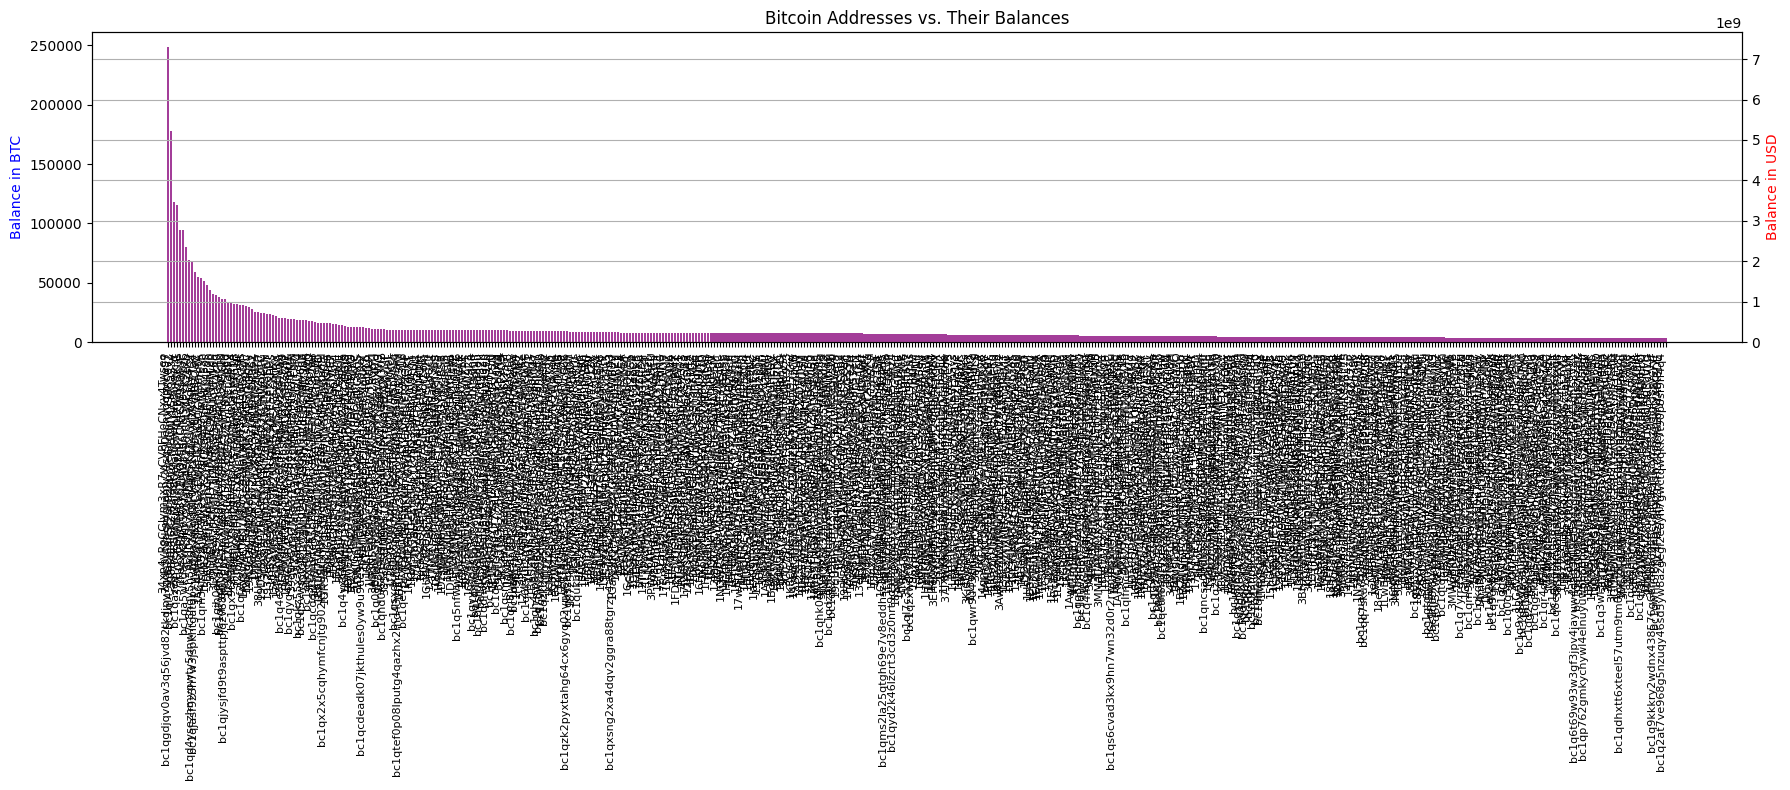

In [ ]:
# Plotting
fig, ax1 = plt.subplots(figsize=(18, 8))

# Twin the axes
ax2 = ax1.twinx()

# Plot data
ax1.bar(addresses, btc_balances, alpha=0.6, color='b', label='Balance (BTC)')
ax2.bar(addresses, usd_balances, alpha=0.4, color='r', label='Balance (USD)')

# Set the y axis label
ax1.set_ylabel('Balance in BTC', color='b')
ax2.set_ylabel('Balance in USD', color='r')

# To make the x-axis more readable
ax1.set_xticklabels(addresses, rotation=90, ha='right', fontsize=8)

# Title and show the plot
plt.title('Bitcoin Addresses vs. Their Balances')
plt.tight_layout()
plt.grid()
plt.show()